In [1]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
import cv2
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from pandas import DataFrame

Using TensorFlow backend.


In [2]:
new_shape = (224, 224)

### Constructing the data

In [3]:
def process(input_file):
    with open(input_file, 'r') as f:
        a = f.readlines()[0]
    a = a.split("\t")
    name = a[0]
    bbox = list(map(int, a[1:5]))
    img = cv2.imread(input_file[:-4] + '.jpg')
    return img, bbox

In [4]:
def vizualize(image, box):
    fig,ax = plt.subplots(1, figsize = (20,10))
    ax.imshow(image[:,:,[2,1,0]])
    rect = Rectangle((box[0],box[1]),box[2],box[3],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [5]:
def resize_im_box(image, box, new_shape):
    resized_img = cv2.resize(image, new_shape)
    
    scale_y = new_shape[0] / image.shape[0]
    scale_x = new_shape[1] / image.shape[1]
    
    resized_box = box.copy()
    resized_box[0] = int(box[0]*scale_x)
    resized_box[2] = int(box[2]*scale_x)
    resized_box[1] = int(box[1]*scale_y)
    resized_box[3] = int(box[3]*scale_y)
    
    return resized_img, resized_box
    

In [6]:
eu_img_buffer = []
eu_box_buffer = []

for input_file in os.listdir("endtoend/eu/"):
    if input_file.endswith('.txt'):
        img, box = process("endtoend/eu/" + input_file)
        img, box = resize_im_box(img, box, new_shape = new_shape)
        eu_img_buffer.append(img)
        eu_box_buffer.append(box)



In [7]:
us_img_buffer = []
us_box_buffer = []

for input_file in os.listdir("endtoend/us/"):
    if input_file.endswith('.txt'):
        img, box = process("endtoend/us/" + input_file)
        img, box = resize_im_box(img, box, new_shape = new_shape)
        us_img_buffer.append(img)
        us_box_buffer.append(box)



In [8]:
br_img_buffer = []
br_box_buffer = []

for input_file in os.listdir("endtoend/br/"):
    if input_file.endswith('.txt'):
        img, box = process("endtoend/br/" + input_file)
        img, box = resize_im_box(img, box, new_shape = new_shape)
        br_img_buffer.append(img)
        br_box_buffer.append(box)



In [9]:
remove_for_vis = 5
img_data_to_consider = eu_img_buffer[:-remove_for_vis] + us_img_buffer[:-remove_for_vis] + br_img_buffer[:-remove_for_vis]
box_data_to_consider = eu_box_buffer[:-remove_for_vis] + us_box_buffer[:-remove_for_vis] + br_box_buffer[:-remove_for_vis]



In [10]:
img_viz = eu_img_buffer[-remove_for_vis:] + us_img_buffer[-remove_for_vis:] + br_img_buffer[-remove_for_vis:]
box_viz = eu_box_buffer[-remove_for_vis:] + us_box_buffer[-remove_for_vis:] + br_box_buffer[-remove_for_vis:]



In [11]:
X_train, X_test, y_train, y_test = train_test_split(np.array(img_data_to_consider), np.array(box_data_to_consider), random_state = 42)

In [37]:
name = "my_VGG_model_1000_bsize_64"
model = keras.models.load_model(name)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [38]:
def make_report(y_train, y_pred_train, y_test, y_pred_test):
    r2_train = r2_score(y_true = y_train, y_pred = y_pred_train)
    r2_test = r2_score(y_true = y_test, y_pred = y_pred_test)
    
    mse_train = mean_squared_error(y_true = y_train, y_pred = y_pred_train)
    mse_test = mean_squared_error(y_true = y_test, y_pred = y_pred_test)
    
    mae_train = mean_absolute_error(y_true = y_train, y_pred = y_pred_train)
    mae_test = mean_absolute_error(y_true = y_test, y_pred = y_pred_test)
    
    return DataFrame(
        data = {
            "R2" : [r2_train, r2_test],
            "MSE" : [mse_train, mse_test],
            "MAE" : [mae_train, mae_test]
        },
        index = ["train", "test"]
    )
    

In [39]:
make_report(y_train, y_pred_train, y_test, y_pred_test)

,MAE,MSE,R2
train,3.716223,27.480730,0.951887
test,3.964757,28.865524,0.934018


In [40]:
def predict_and_vizualize(img_test, coords):
    f = np.array([img_test])
    pred = model.predict(f)

    pred = pred.reshape((pred.shape[1]))

    
    fig,ax = plt.subplots(1, figsize = (20,10))


    # Display the image
    ax.imshow(img_test[:,:,[2,1,0]])

    # Create a Rectangle patch
    rect_gt =Rectangle((coords[0],coords[1]),coords[2] ,coords[3] ,linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect_gt)
    
    rect_pred =Rectangle((int(pred[0]),int(pred[1])),int(pred[2]) ,int(pred[3]) ,linewidth=1,edgecolor='g',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect_pred)

    plt.show()
    
    return list(map(int, pred))

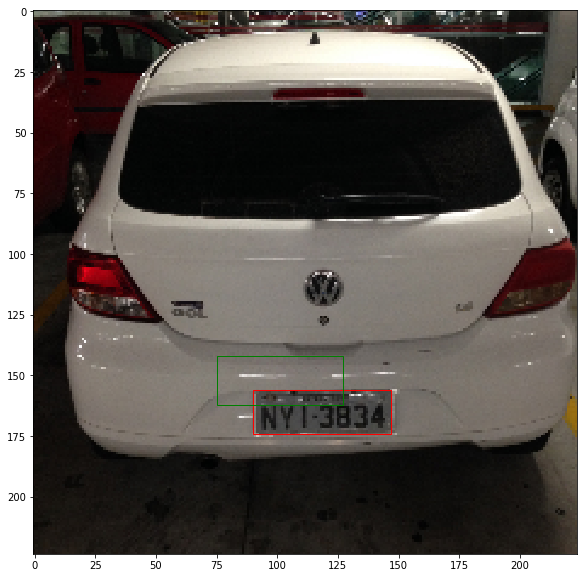

[75, 142, 52, 20] [83, 113, 65, 21]


In [48]:
sample = -1
pred_box = predict_and_vizualize(X_test[sample,:,:,:], y_test[sample,:])
print(pred_box, box_viz[sample])